In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
test_query = f"""
SELECT repo_name from repo where repo_id = '26983';
   """
test = pd.read_sql_query(test_query, con=engine)
repo_name = test.repo_name[0]
print(repo_name)

postfacto


In [13]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

   repo_id        repo_name                              repo_path
0    26235        concourse               github.com/pcfdev-forks/
1    28051        concourse                  github.com/concourse/
2    28030         sonobuoy               github.com/vmware-tanzu/
3    27913          clarity                     github.com/vmware/
4    26983        postfacto                    github.com/pivotal/
5    27169             gpdb                github.com/pivotal-gss/
6    25857             gpdb               github.com/greenplum-db/
7    25432  rabbitmq-server                   github.com/rabbitmq/
8    26600             gpdb  github.com/Pivotal-Field-Engineering/
9    27043            kpack                    github.com/pivotal/


In [21]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy

In [22]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

start = current - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-03-11'
'2019-03-12'


In [80]:
# Monthly PRs closed
pr_monthDF = pd.DataFrame()
for value in repo_dict: 
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                                AND pull_requests.pr_src_state = 'closed'  
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value

    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
    else: 
        pr_monthDF = pr_monthDFa
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)

pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].apply('{:0>2}'.format)
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+ pr_monthDF['month'].map(str)


In [81]:

print(pr_monthDF['month'])

0     03
1     04
2     05
3     06
4     07
5     08
6     09
7     10
8     11
9     12
10    01
11    02
Name: month, dtype: object


In [82]:
pr_sustainDF = pd.DataFrame()
pr_sustainDF['yearmonth'] = pr_monthDF['yearmonth']
pr_sustainDF['repo_name'] = pr_monthDF['repo_name']
pr_sustainDF['repo_id'] = pr_monthDF['repo_id']
pr_sustainDF['closed_total'] = pr_monthDF['total_prs_open_closed']
print(pr_sustainDF)

   yearmonth         repo_name  repo_id  closed_total
0     201903  spring-framework    25663            76
1     201904  spring-framework    25663            24
2     201905  spring-framework    25663            50
3     201906  spring-framework    25663            28
4     201907  spring-framework    25663            25
5     201908  spring-framework    25663            49
6     201909  spring-framework    25663            41
7     201910  spring-framework    25663            48
8     201911  spring-framework    25663            46
9     201912  spring-framework    25663            37
10    202001  spring-framework    25663            51
11    202002  spring-framework    25663            46


In [83]:
# Monthly PRs ALL - removed where pull_requests.pr_src_state = 'closed' 
pr_monthDF = pd.DataFrame()

for value in repo_dict: 
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {today}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
    else: 
        pr_monthDF = pr_monthDFa
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)


In [86]:
pr_sustainDF['all_total'] = pr_monthDF['total_prs_open_closed']
pr_sustainDF['diff'] = pr_sustainDF['all_total'] - pr_sustainDF['closed_total']
print(pr_sustainDF,'\n')
#print((pr_sustainDF['diff']).describe())

   yearmonth         repo_name  repo_id  closed_total  all_total  diff
0     201903  spring-framework    25663            76         77     1
1     201904  spring-framework    25663            24         29     5
2     201905  spring-framework    25663            50         53     3
3     201906  spring-framework    25663            28         29     1
4     201907  spring-framework    25663            25         34     9
5     201908  spring-framework    25663            49         51     2
6     201909  spring-framework    25663            41         50     9
7     201910  spring-framework    25663            48         55     7
8     201911  spring-framework    25663            46         60    14
9     201912  spring-framework    25663            37         43     6
10    202001  spring-framework    25663            51         63    12
11    202002  spring-framework    25663            46         58    12 



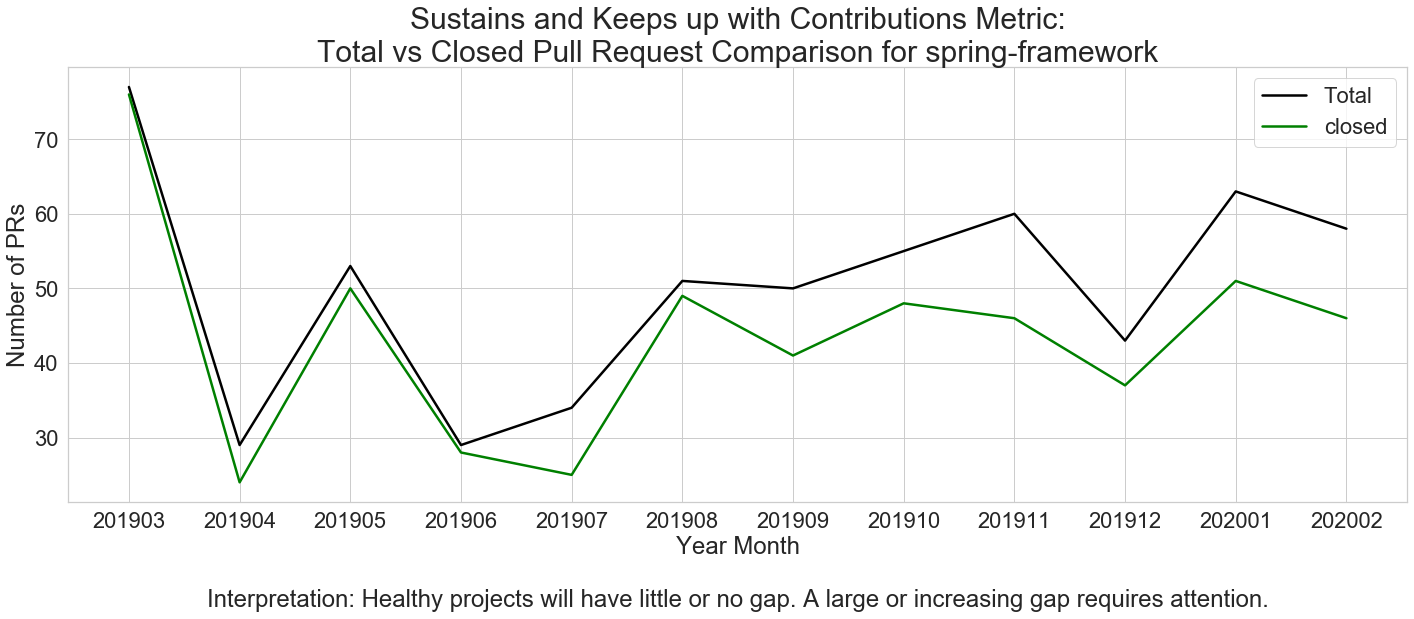

In [87]:
pr_sustainDF['repo_id'] = pr_sustainDF['repo_id'].map(int)
#pr_sustainDF['yearmonth'] = pr_sustainDF['yearmonth'].map(str)
pr_sustainDF.set_index('repo_id', 'yearmonth')


sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

title = "Sustains and Keeps up with Contributions Metric:\nTotal vs Closed Pull Request Comparison for " + pr_sustainDF['repo_name'][0]

plottermonth = sns.lineplot(x='yearmonth', y='all_total', data=pr_sustainDF, sort=False, color='black', label='Total', linewidth=2.5)
plottermonth = sns.lineplot(x='yearmonth', y='closed_total', data=pr_sustainDF, sort=False, color='green', label='closed', linewidth=2.5, linestyle='dashed').set_title(title, fontsize=30) 

plottermonthlabels = ax.set_xticklabels(pr_sustainDF['yearmonth'])
plottermonthlabels = ax.set_ylabel('Number of PRs')
plottermonthlabels = ax.set_xlabel('Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.')